
# Shefu — Notebook de **Regresión Anti‑Promedio** (Quantile + Multi‑Task + Pesos de Cola)

**Objetivo:** Reducir el sesgo a promediar en la predicción de **`score_clean`** sin recolectar nuevas fotos.

**Idea central:** entrenamos una cabeza de **regresión cuantil** (`q10`, `q50`, `q90`) + una cabeza auxiliar de **4 flags binarios** (cocción/presentación/ingredientes/balance visual).  
El **loss** combina **pinball loss** (cuantiles) + **BCE** (flags) + **regularizador de orden** (`q10 ≤ q50 ≤ q90`).  
Además, aplicamos:
- **Muestreo sensible a colas** (más peso a ejemplos alejados de la media).
- **MixUp** fotográfico compatible con regresión/flags.
- **Split estratificado por bins** para equilibrar las bandas de nota.



## Requisitos
- tensorFlow 2.12+ (o similar), NumPy, Pandas, Matplotlib.
- scikit-learn para calibración post‑hoc.
- Estructura de `train_df`/`val_df` similar a la que ya usas:
  - `crop_path` 
  - `score_clean` (0–100)
  - `pan_quemado`, `falta_ingrediente`, `desordenado`, `buen_balance_visual` (0/1)



In [226]:

import os, math, json, random
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow.keras as K
import matplotlib.pyplot as plt

# (Opcional) para calibración post-hoc
try:
    from sklearn.isotonic import IsotonicRegression
    SKLEARN_AVAILABLE = True
except Exception:
    SKLEARN_AVAILABLE = False

print(tf.__version__)


2.15.0


In [227]:
import os

CROPS_DIR = "data/crops_yolo"  
os.makedirs(CROPS_DIR, exist_ok=True)
print("Ruta de crops creada:", os.path.abspath(CROPS_DIR))


Ruta de crops creada: c:\Users\anays\OneDrive\Escritorio\shefu_vc\shefu\completos_regresion\data\crops_yolo


In [228]:
import os, shutil
from pathlib import Path

# === Configuración ===
DATA_CSV_PATH = 'project-2-at-2025-09-12-06-46-b36c7e7f.csv'
IMAGES_ROOT  = 'dataset/train/images'
YOLO_WEIGHTS = r"C:\Users\anays\OneDrive\Escritorio\shefu_vc\shefu\runs_detector1\rf_completos22\weights\best.pt"    
CROPS_DIR    = 'dataset/crops'

# === Eliminar crops anteriores ===
if os.path.exists(CROPS_DIR):
    shutil.rmtree(CROPS_DIR)
os.makedirs(CROPS_DIR, exist_ok=True)

print("carpeta de crops limpia y creada:", os.path.abspath(CROPS_DIR))


carpeta de crops limpia y creada: c:\Users\anays\OneDrive\Escritorio\shefu_vc\shefu\completos_regresion\dataset\crops


In [229]:
import pandas as pd, re

df = pd.read_csv(DATA_CSV_PATH)
print("Total filas en CSV original:", len(df))

def extraer_score(x):
    match = re.search(r'"number":\s*([0-9]+)', str(x))
    return float(match.group(1)) if match else None

df["score_clean"] = df["score"].apply(extraer_score)

def parse_flags(m):
    text = str(m)
    return pd.Series({
        "pan_quemado": int("Pan quemado" in text),
        "falta_ingrediente": int("Falta de ingrediente" in text),
        "desordenado": int("Desordenado" in text),
        "buen_balance_visual": int("Buen balance visual" in text),
    })

flags_df = df["motivo"].apply(parse_flags)
df = pd.concat([df, flags_df], axis=1)


Total filas en CSV original: 197


In [230]:
from ultralytics import YOLO
import cv2
import numpy as np
from tqdm import tqdm

# Cargar detector
detector = YOLO(YOLO_WEIGHTS)

def yolo_crop_to_file(img_path, save_dir=CROPS_DIR, conf=0.25):
    """Recorta el primer bounding box detectado y guarda la imagen."""
    base = os.path.basename(img_path)
    name, ext = os.path.splitext(base)
    crop_path = os.path.join(save_dir, f"{name}_crop{ext}")

    # Saltar si ya existe
    if os.path.exists(crop_path):
        return crop_path

    # Detección
    results = detector(img_path, conf=conf, verbose=False)
    boxes = results[0].boxes.xyxy.cpu().numpy().astype(int) if len(results) > 0 else np.array([])

    if boxes.shape[0] == 0:
        return None

    x1, y1, x2, y2 = boxes[0]
    img = cv2.imread(img_path)
    if img is None:
        return None

    h, w = img.shape[:2]
    x1, y1 = max(0, x1), max(0, y1)
    x2, y2 = min(w, x2), min(h, y2)

    crop = img[y1:y2, x1:x2]
    if crop.size == 0:
        return None

    cv2.imwrite(crop_path, crop)
    return crop_path


In [231]:
import pandas as pd
df = pd.read_csv(DATA_CSV_PATH)
print("Columnas del CSV:", df.columns.tolist())
df.head(3)


Columnas del CSV: ['annotation_id', 'annotator', 'comentario', 'created_at', 'data', 'id', 'lead_time', 'motivo', 'score', 'updated_at']


,annotation_id,annotator,comentario,created_at,data,id,lead_time,motivo,score,updated_at
0,4,1,NaN,2025-09-12T03:31:53.514237Z,/data/upload/2/8bb62781-13_jpg.rf.47f03fb9cb7d...,1,169.421,Desordenado,"[{""number"":60}]",2025-09-12T03:31:53.514299Z
1,5,1,NaN,2025-09-12T03:32:10.625150Z,/data/upload/2/7a51d475-31_jpg.rf.da60e32e87c9...,2,16.550,Buen balance visual,"[{""number"":85}]",2025-09-12T03:32:10.625172Z
2,6,1,NaN,2025-09-12T03:32:16.742523Z,/data/upload/2/127c1049-32_jpg.rf.fd34c321719a...,3,5.603,Buen balance visual,"[{""number"":85}]",2025-09-12T03:32:16.742585Z


In [232]:
df["filename"] = df["data"].apply(lambda p: os.path.basename(str(p)))
df["img_fullpath"] = df["filename"].apply(lambda f: os.path.join(IMAGES_ROOT, f))

df["exists"] = df["img_fullpath"].apply(os.path.exists)
print("Imágenes encontradas:", df["exists"].sum(), "/", len(df))

df = df[df["exists"]]


Imágenes encontradas: 197 / 197


In [233]:
crops = []
for path in tqdm(df["img_fullpath"], desc="Generando crops"):
    crop_path = yolo_crop_to_file(path)
    crops.append(crop_path)

df["crop_path"] = crops
df = df[df["crop_path"].notnull()]

print("crops generados:", len(df))


Generando crops: 100%|██████████| 197/197 [00:09<00:00, 20.81it/s]

crops generados: 197


In [234]:
import re
import pandas as pd

def extraer_score(x):
    match = re.search(r'"number":\s*([0-9]+)', str(x))
    return float(match.group(1)) if match else None

df["score_clean"] = df["score"].apply(extraer_score)

def parse_flags(m):
    text = str(m)
    return pd.Series({
        "pan_quemado": int("Pan quemado" in text),
        "falta_ingrediente": int("Falta de ingrediente" in text),
        "desordenado": int("Desordenado" in text),
        "buen_balance_visual": int("Buen balance visual" in text),
    })

flags_df = df["motivo"].apply(parse_flags)
df = pd.concat([df, flags_df], axis=1)

df["exists"] = df["crop_path"].apply(os.path.exists)
print("Crops encontrados:", df["exists"].sum(), "/", len(df))
df = df[df["exists"]]

#csv para entrenar
cols = ["crop_path", "score_clean", "pan_quemado", "falta_ingrediente", "desordenado", "buen_balance_visual"]
df_final = df[cols].dropna(subset=["score_clean"])
df_final.to_csv("train_metadata.csv", index=False)

print("train_metadata.csv creado con", len(df_final), "filas")
print("Columnas finales:", df_final.columns.tolist())
print("Ejemplo de ruta:", df_final["crop_path"].iloc[0])
df = pd.read_csv("train_metadata.csv")
df["crop_path"] = df["crop_path"].apply(lambda p: Path(p).as_posix())
df.to_csv("train_metadata.csv", index=False)

print("Rutas normalizadas (ejemplo):", df["crop_path"].iloc[0])


Crops encontrados: 197 / 197
train_metadata.csv creado con 196 filas
Columnas finales: ['crop_path', 'score_clean', 'pan_quemado', 'falta_ingrediente', 'desordenado', 'buen_balance_visual']
Ejemplo de ruta: dataset/crops\8bb62781-13_jpg.rf.47f03fb9cb7dc92fcbd7556f1251b96b_crop.jpg
Rutas normalizadas (ejemplo): dataset/crops/8bb62781-13_jpg.rf.47f03fb9cb7dc92fcbd7556f1251b96b_crop.jpg


In [235]:
import pandas as pd
from pathlib import Path

# Cargar el CSV final
df = pd.read_csv("train_metadata.csv")

def normalizar_ruta(p):
    # Quita slash inicial y normaliza separadores
    p = str(p).lstrip("/\\")
    return str(Path(p).as_posix())

df["crop_path"] = df["crop_path"].apply(normalizar_ruta)
df.to_csv("train_metadata_fixed.csv", index=False)

print("Rutas corregidas y guardadas en train_metadata_fixed.csv")
print("Ejemplo:", df["crop_path"].iloc[0])


cols = ["crop_path","score_clean","pan_quemado","falta_ingrediente","desordenado","buen_balance_visual"]
df_final = df[cols].dropna(subset=["score_clean"])
df_final.to_csv("train_metadata_fixed.csv", index=False)

print("train_metadata_fixed.csv creado con", len(df_final), "filas")
print("Ejemplo de ruta:", df_final["crop_path"].iloc[0])


Rutas corregidas y guardadas en train_metadata_fixed.csv
Ejemplo: dataset/crops/8bb62781-13_jpg.rf.47f03fb9cb7dc92fcbd7556f1251b96b_crop.jpg
train_metadata_fixed.csv creado con 196 filas
Ejemplo de ruta: dataset/crops/8bb62781-13_jpg.rf.47f03fb9cb7dc92fcbd7556f1251b96b_crop.jpg


## Configuración y rutas

In [236]:

# Ajusta a tus rutas reales
DATA_CSV = "train_metadata_fixed.csv"
IMG_ROOT = "C:/Users/anays/OneDrive/Escritorio/shefu_vc/shefu/completos_regresion"
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
SEED = 42

tf.random.set_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)



## Carga de datos y EDA rápida

**Decisión:** Usamos **bins estratificados** para mantener proporciones de notas en train/val y **visualizamos** la distribución para verificar colas.


score_bin
0    33
1    17
2    41
3    70
4    35
Name: count, dtype: int64


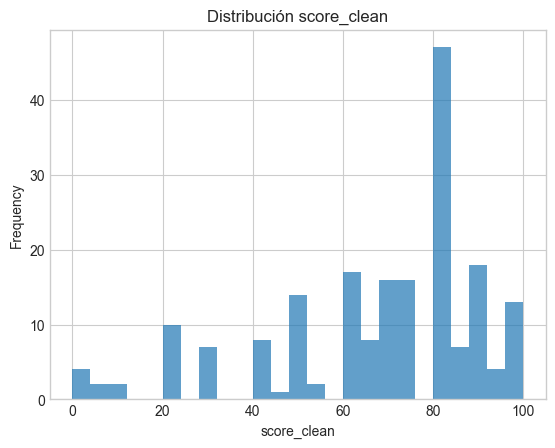

In [237]:

df = pd.read_csv(DATA_CSV)
assert {"crop_path","score_clean","pan_quemado","falta_ingrediente","desordenado","buen_balance_visual"}.issubset(df.columns), \
    "Faltan columnas esperadas en el CSV."

df["score_clean"] = df["score_clean"].astype(np.float32).clip(0, 100)
mu = df["score_clean"].mean()
std = df["score_clean"].std()

# Bins
bins = [0, 40, 55, 70, 85, 100]
df["score_bin"] = pd.cut(df["score_clean"], bins=bins, include_lowest=True, labels=False)

print(df["score_bin"].value_counts().sort_index())

plt.figure()
df["score_clean"].plot(kind="hist", bins=25, alpha=0.7)
plt.title("Distribución score_clean")
plt.xlabel("score_clean")
plt.show()



## Split estratificado por bandas de score

**Decisión:** Aseguramos representación de **extremos** (colas) en `val` para evaluar si dejamos de promediar.


In [238]:

from sklearn.model_selection import StratifiedGroupKFold, StratifiedKFold

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED)
# primera partición para train/val
train_idx, val_idx = next(skf.split(df, df["score_bin"]))

train_df = df.iloc[train_idx].reset_index(drop=True)
val_df   = df.iloc[val_idx].reset_index(drop=True)

print("train:", train_df.shape, "val:", val_df.shape)


train: (156, 7) val: (40, 7)



## Pipeline de datos (tf.data) con **MixUp** y **pesos de cola**

**Decisiones:**  
- **MixUp**: reduce sobreajuste y ayuda a mover el modelo fuera del promedio “puro”.
- **Pesos de cola**: ejemplos lejos de la media obtienen mayor peso (ya lo usabas, se refuerza).


In [239]:

AUTOTUNE = tf.data.AUTOTUNE

def read_image(path):
    img = tf.io.read_file(path)
    img = tf.io.decode_image(img, channels=3, expand_animations=False)
    img = tf.image.resize(img, IMG_SIZE)
    img = tf.cast(img, tf.float32) / 255.0
    return img

def load_and_augment(path, training=True):
    img = read_image(path)
    if training:
        img = tf.image.random_flip_left_right(img)
        img = tf.image.random_brightness(img, 0.1)
        img = tf.image.random_contrast(img, 0.9, 1.1)
        # jitter geométrico suave
        img = tf.image.resize_with_crop_or_pad(img, IMG_SIZE[0]+8, IMG_SIZE[1]+8)
        img = tf.image.random_crop(img, size=[IMG_SIZE[0], IMG_SIZE[1], 3])
    return img

def build_ds(frame, training=True):
    x_paths = frame["crop_path"].values
    y_score = (frame["score_clean"].values / 100.0).astype(np.float32)
    y_flags = frame[["pan_quemado","falta_ingrediente","desordenado","buen_balance_visual"]].values.astype(np.float32)

    # pesos de cola (distancia a la media original en escala 0-100)
    w = (1.0 + 0.6 * np.abs(frame["score_clean"].values - frame["score_clean"].mean()) / 50.0).astype(np.float32)

    ds_x = tf.data.Dataset.from_tensor_slices(x_paths).map(
        lambda p: load_and_augment(tf.strings.join([IMG_ROOT, "/", p]), training=training),
        num_parallel_calls=AUTOTUNE
    )
    ds_y = tf.data.Dataset.from_tensor_slices({"score": y_score, "flags": y_flags})
    ds_w = tf.data.Dataset.from_tensor_slices(w)
    ds = tf.data.Dataset.zip((ds_x, ds_y, ds_w))

    if training:
        ds = ds.shuffle(1024, seed=SEED)

        # MixUp simple
        def mixup(x1, y1, w1, x2, y2, w2, alpha=0.4):
            lam = tf.squeeze(tf.random.gamma([1], alpha, beta=1.0))
            lam = tf.clip_by_value(lam, 0.0, 1.0)
            x = lam * x1 + (1.0 - lam) * x2
            y = {
                "score": lam * y1["score"] + (1.0 - lam) * y2["score"],
                "flags": lam * y1["flags"] + (1.0 - lam) * y2["flags"],
            }
            w = lam * w1 + (1.0 - lam) * w2
            return x, y, w

        ds2 = ds.shuffle(1024, seed=SEED)
        ds = tf.data.Dataset.zip((ds, ds2)).map(
            lambda a, b: mixup(a[0], a[1], a[2], b[0], b[1], b[2]),
            num_parallel_calls=AUTOTUNE
        )

    ds = ds.map(lambda x, y, w: ((x, y), w), num_parallel_calls=AUTOTUNE)
    ds = ds.batch(BATCH_SIZE).prefetch(AUTOTUNE)
    return ds

train_ds = build_ds(train_df, training=True)
val_ds   = build_ds(val_df, training=False)



## Pérdidas: **Pinball (cuantiles)** + **Regularizador de orden**
- `pinball(y, y_qτ, τ)` ataca la **asimetría** y evita colapsar al promedio.
- Penalizamos si `q10 > q50` o `q50 > q90`.


In [240]:

def pinball_loss(y_true, y_pred, tau):
    # y_true, y_pred en [0,1]
    e = y_true - y_pred
    return tf.reduce_mean(tf.maximum(tau*e, (tau-1.0)*e))

def order_regularizer(q10, q50, q90, lam=1.0):
    # penaliza violaciones de orden cuantil
    v1 = tf.nn.relu(q10 - q50)
    v2 = tf.nn.relu(q50 - q90)
    return lam * tf.reduce_mean(v1 + v2)



## Modelo: MobileNetV3Small (transfer learning) + Cabezas
- **Cabeza cuantiles:** `q10`, `q50`, `q90` (activación lineal)
- **Cabeza flags auxiliar:** 4 sigmoides con **BCE** (solo ayuda al *feature learning*)


In [241]:

def build_model(img_size=IMG_SIZE):
    base = tf.keras.applications.MobileNetV3Small(
        input_shape=(img_size[0], img_size[1], 3),
        include_top=False,
        weights="imagenet"
    )
    base.trainable = False  # fase 1: congelado

    inp_img = K.Input(shape=(img_size[0], img_size[1], 3), name="image")
    x = base(inp_img, training=False)
    x = K.layers.GlobalAveragePooling2D()(x)
    x = K.layers.Dropout(0.3)(x)
    h = K.layers.Dense(512, activation="relu")(x)
    h = K.layers.Dropout(0.3)(h)

    # cuantiles (en [0,1])
    q10 = K.layers.Dense(1, activation="sigmoid", name="q10")(h)
    q50 = K.layers.Dense(1, activation="sigmoid", name="q50")(h)
    q90 = K.layers.Dense(1, activation="sigmoid", name="q90")(h)

    # auxiliares
    out_flags = K.layers.Dense(4, activation="sigmoid", name="flags_out")(h)

    # entrada de labels para permitir pérdidas personalizadas en model.fit
    inp_score = K.Input(shape=(), name="score")
    inp_flags = K.Input(shape=(4,), name="flags")

    model = K.Model(inputs=[inp_img, inp_score, inp_flags], outputs=[q10, q50, q90, out_flags])
    return model

model = build_model()
model.summary()


Model: "model_11"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 image (InputLayer)          [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 MobilenetV3small (Function  (None, 7, 7, 576)            939120    ['image[0][0]']               
 al)                                                                                              
                                                                                                  
 global_average_pooling2d_1  (None, 576)                  0         ['MobilenetV3small[0][0]']    
 1 (GlobalAveragePooling2D)                                                                       
                                                                                           


## Entrenamiento: `Model.fit` con pérdidas personalizadas

**Decisión:** Implementamos un `train_step` para combinar:
- `pinball(y, q10, 0.1) + pinball(y, q50, 0.5) + pinball(y, q90, 0.9)`
- `order_regularizer(q10,q50,q90, λ)`
- `BCE(flags, flags_out)` con peso auxiliar.


In [242]:
class QuantileTrainer(tf.keras.Model):
    def __init__(self, base_model, lam_order=2.0, w_flags=0.3, **kwargs):
        super().__init__(**kwargs)
        self.base = base_model
        self.lam_order = lam_order
        self.w_flags = w_flags

        self.loss_tracker = K.metrics.Mean(name="loss")
        self.mae_q50 = K.metrics.MeanAbsoluteError(name="mae_q50")
        self.bce_flags = K.metrics.Mean(name="bce_flags")

    def compile(self, optimizer):
        super().compile()
        self.optimizer = optimizer
        self.bce = K.losses.BinaryCrossentropy(from_logits=False)

    def train_step(self, data):
        (x, y), w = data
        img = x
        y_score = tf.expand_dims(y["score"], axis=-1)
        y_flags = y["flags"]

        with tf.GradientTape() as tape:
            # y["score"], y["flags"]
            q10, q50, q90, fhat = self.base([img, y["score"], y["flags"]], training=True)

            l_q = pinball_loss(y_score, q10, 0.1) + \
                  pinball_loss(y_score, q50, 0.5) + \
                  pinball_loss(y_score, q90, 0.9)

            l_ord = order_regularizer(q10, q50, q90, lam=self.lam_order)
            bce_elem = K.losses.binary_crossentropy(y_flags, fhat)
            l_flags = tf.reduce_mean(bce_elem)

            total_loss = l_q + l_ord + self.w_flags * l_flags

        grads = tape.gradient(total_loss, self.base.trainable_variables)
        self.optimizer.apply_gradients(zip(grads, self.base.trainable_variables))

        self.loss_tracker.update_state(total_loss)
        self.mae_q50.update_state(y_score, q50)
        self.bce_flags.update_state(l_flags)

        return {"loss": self.loss_tracker.result(),
                "mae_q50": self.mae_q50.result(),
                "bce_flags": self.bce_flags.result()}

    def test_step(self, data):
        (x, y), w = data
        img = x
        y_score = tf.expand_dims(y["score"], axis=-1)
        y_flags = y["flags"]

        q10, q50, q90, fhat = self.base([img, y["score"], y["flags"]], training=False)

        l_q = pinball_loss(y_score, q10, 0.1) + \
              pinball_loss(y_score, q50, 0.5) + \
              pinball_loss(y_score, q90, 0.9)
        l_ord = order_regularizer(q10, q50, q90, lam=self.lam_order)
        bce_elem = K.losses.binary_crossentropy(y_flags, fhat)
        l_flags = tf.reduce_mean(bce_elem)

        total_loss = l_q + l_ord + self.w_flags * l_flags

        self.loss_tracker.update_state(total_loss)
        self.mae_q50.update_state(y_score, q50)
        self.bce_flags.update_state(l_flags)
        return {
            "loss": self.loss_tracker.result(),
            "mae_q50": self.mae_q50.result(),
            "bce_flags": self.bce_flags.result()
        }
    @property
    def metrics(self):
        return [self.loss_tracker, self.mae_q50, self.bce_flags]



## Callbacks y Entrenamiento — **Fase 1 (backbone congelado)**


In [243]:

trainer = QuantileTrainer(model)
trainer.compile(optimizer=tf.keras.optimizers.Adam(1e-3))

ckpt = K.callbacks.ModelCheckpoint("best_quantile.h5", monitor="val_mae_q50", mode="min",
                                   save_best_only=True, save_weights_only=True)
es   = K.callbacks.EarlyStopping(monitor="val_mae_q50", mode="min", patience=7, restore_best_weights=True)

hist = trainer.fit(
    train_ds,
    validation_data=val_ds,
    epochs=30,
    callbacks=[ckpt, es],
    verbose=1
)


Epoch 1/30
5/5 [==============================] - 5s 346ms/step - loss: 0.5519 - mae_q50: 0.2160 - bce_flags: 0.6215 - val_loss: 0.3507 - val_mae_q50: 0.1794 - val_bce_flags: 0.5450
Epoch 2/30
5/5 [==============================] - 1s 125ms/step - loss: 0.3251 - mae_q50: 0.1767 - bce_flags: 0.5142 - val_loss: 0.3382 - val_mae_q50: 0.1883 - val_bce_flags: 0.4789
Epoch 3/30
5/5 [==============================] - 1s 155ms/step - loss: 0.3357 - mae_q50: 0.1929 - bce_flags: 0.5145 - val_loss: 0.3328 - val_mae_q50: 0.1746 - val_bce_flags: 0.4781
Epoch 4/30
5/5 [==============================] - 1s 128ms/step - loss: 0.3477 - mae_q50: 0.1834 - bce_flags: 0.5579 - val_loss: 0.3383 - val_mae_q50: 0.1902 - val_bce_flags: 0.4795
Epoch 5/30
5/5 [==============================] - 1s 120ms/step - loss: 0.3336 - mae_q50: 0.1885 - bce_flags: 0.5043 - val_loss: 0.3328 - val_mae_q50: 0.1758 - val_bce_flags: 0.4885
Epoch 6/30
5/5 [==============================] - 1s 126ms/step - loss: 0.3254 - mae_q50: 


## Fine‑tuning — **Fase 2** (descongelar últimas capas)
**Decisión:** desbloqueamos ~30% final del backbone para especializar filtros.


In [244]:

# descongelar parte final
layers = trainer.base.layers[1].layers  # acceder a base -> MobileNetV3
n = len(layers)
for i, lyr in enumerate(layers):
    lyr.trainable = (i > int(0.7 * n))  # último 30%

trainer.compile(optimizer=K.optimizers.Adam(1e-5))

hist2 = trainer.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10,
    callbacks=[ckpt, es],
    verbose=1
)


Epoch 1/10
5/5 [==============================] - 4s 323ms/step - loss: 0.3084 - mae_q50: 0.1617 - bce_flags: 0.4939 - val_loss: 0.3314 - val_mae_q50: 0.1733 - val_bce_flags: 0.4806
Epoch 2/10
5/5 [==============================] - 1s 123ms/step - loss: 0.3168 - mae_q50: 0.1785 - bce_flags: 0.4881 - val_loss: 0.3314 - val_mae_q50: 0.1734 - val_bce_flags: 0.4805
Epoch 3/10
5/5 [==============================] - 1s 118ms/step - loss: 0.3251 - mae_q50: 0.1707 - bce_flags: 0.5295 - val_loss: 0.3315 - val_mae_q50: 0.1735 - val_bce_flags: 0.4805
Epoch 4/10
5/5 [==============================] - 1s 124ms/step - loss: 0.3176 - mae_q50: 0.1770 - bce_flags: 0.4952 - val_loss: 0.3315 - val_mae_q50: 0.1737 - val_bce_flags: 0.4804
Epoch 5/10
5/5 [==============================] - 1s 125ms/step - loss: 0.3071 - mae_q50: 0.1641 - bce_flags: 0.5057 - val_loss: 0.3317 - val_mae_q50: 0.1738 - val_bce_flags: 0.4804
Epoch 6/10
5/5 [==============================] - 1s 121ms/step - loss: 0.3204 - mae_q50: 

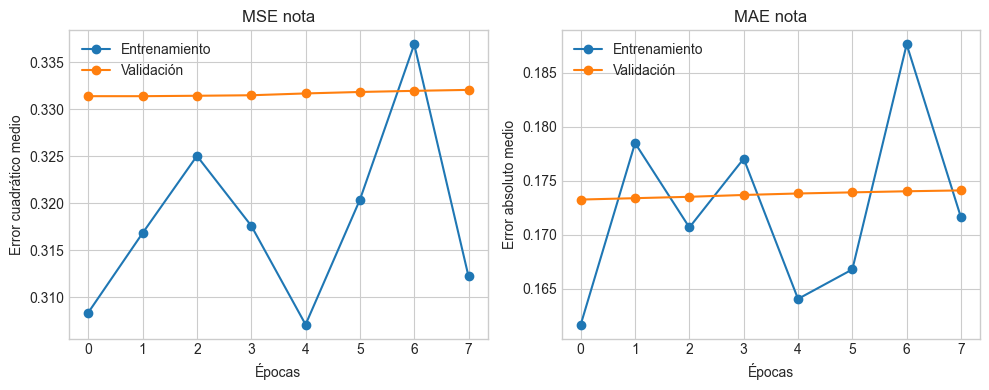

In [245]:
plt.style.use('seaborn-v0_8-whitegrid')

fig, ax = plt.subplots(1, 2, figsize=(10,4))

# MSE
ax[0].plot(hist2.history['loss'], 'o-', label='Entrenamiento')
ax[0].plot(hist2.history['val_loss'], 'o-', label='Validación')
ax[0].set_title('MSE nota')
ax[0].set_xlabel('Épocas')
ax[0].set_ylabel('Error cuadrático medio')
ax[0].legend()

# MAE
ax[1].plot(hist2.history['mae_q50'], 'o-', label='Entrenamiento')
ax[1].plot(hist2.history['val_mae_q50'], 'o-', label='Validación')
ax[1].set_title('MAE nota')
ax[1].set_xlabel('Épocas')
ax[1].set_ylabel('Error absoluto medio')
ax[1].legend()

plt.tight_layout()
plt.show()


C:\Users\anays\AppData\Local\Temp\ipykernel_54212\2309598286.py:37: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  q10, q50, q90 = [float(np.clip(v, 0, 1) * 100.0) for v in (q10, q50, q90)]


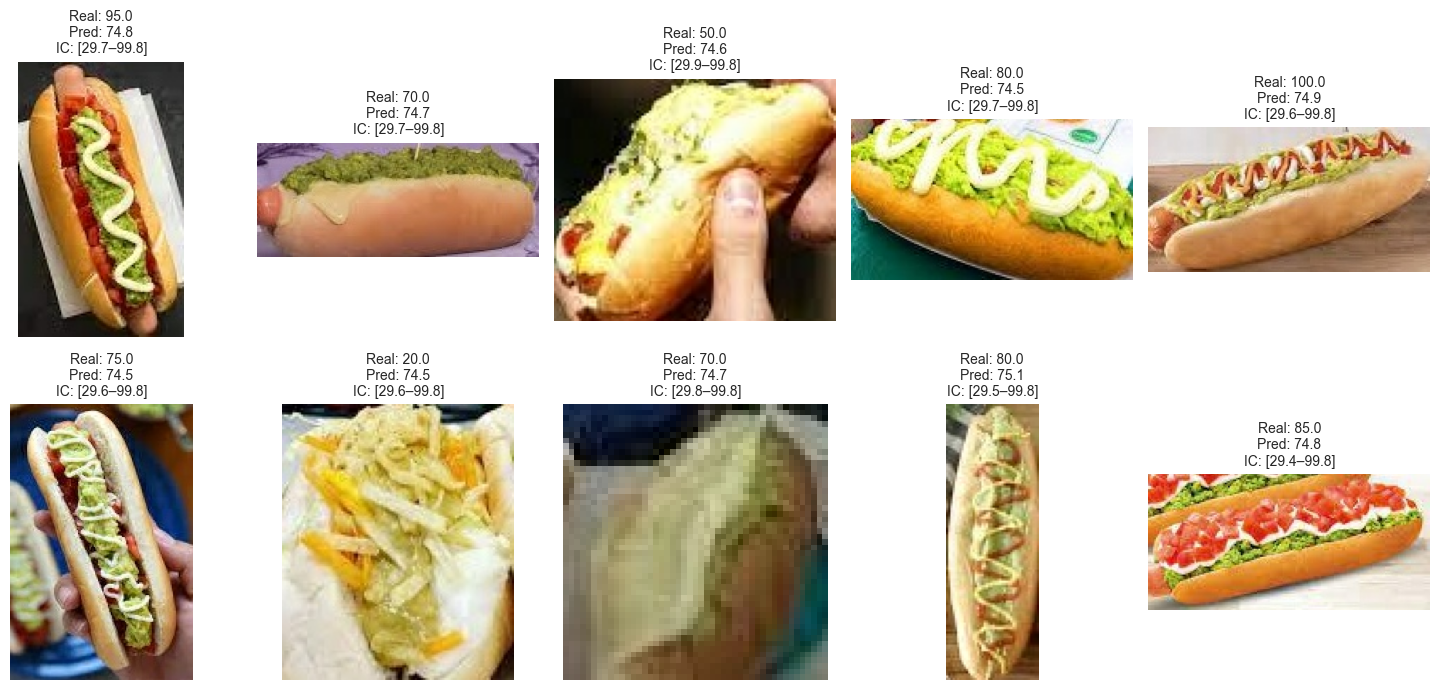

In [246]:

import os, random
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

IMG_SIZE = 224

#  cargar el modelo base 
try:
    infer_model = trainer.base 
except NameError:
    infer_model = tf.keras.models.load_model("best_quantile.h5", compile=False)

#  elegir muestras aleatorias del set de validación 
samples = val_df.sample(10, random_state=42)

plt.figure(figsize=(15, 7))

for i, row in enumerate(samples.itertuples(), 1):
    path = row.crop_path
    if not os.path.exists(path):
        continue

    #   preparar imagen  
    img = tf.image.decode_jpeg(tf.io.read_file(path), channels=3)
    img_resized = tf.image.resize(img, (IMG_SIZE, IMG_SIZE))
    img_norm = tf.cast(img_resized, tf.float32) / 255.0
    img_input = tf.expand_dims(img_norm, 0)

    #   dummy inputs para score y flags (no usados en inferencia real)  
    dummy_score = tf.zeros((1,))     # se requiere por la firma del modelo
    dummy_flags = tf.zeros((1, 4))   # 4 flags

    #   inferencia  
    q10, q50, q90, fhat = infer_model.predict([img_input, dummy_score, dummy_flags], verbose=0)

    q10, q50, q90 = [float(np.clip(v, 0, 1) * 100.0) for v in (q10, q50, q90)]
    real = row.score_clean

    #   mostrar  
    plt.subplot(2, 5, i)
    plt.imshow(img.numpy().astype("uint8"))
    plt.axis("off")
    plt.title(f"Real: {real:.1f}\nPred: {q50:.1f}\nIC: [{q10:.1f}–{q90:.1f}]",
              fontsize=10)

plt.tight_layout()
plt.show()


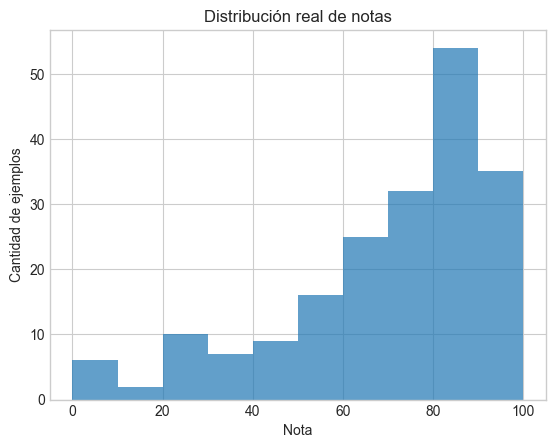

In [247]:
import matplotlib.pyplot as plt
df = pd.read_csv("train_metadata.csv")
plt.hist(df["score_clean"], bins=10, alpha=0.7)
plt.title("Distribución real de notas")
plt.xlabel("Nota")
plt.ylabel("Cantidad de ejemplos")
plt.show()


In [248]:
mu = train_df["score_clean"].mean()
train_df["weight"] = 1.0 + 0.7 * np.abs(train_df["score_clean"] - mu) / 50.0



## Evaluación 
**Decisiones de diseño de evaluación:**
- Reportar **MAE por bandas** (colas vs centro).
- Curvas de **calibración** y análisis de **residuales**.
- Mostrar la **cobertura cuantil**: % de etiquetas que caen entre `q10` y `q90`.


MAE global (q50): 17.326
MAE banda 0-40: 50.568
MAE banda 40-55: 28.588
MAE banda 55-70: 14.723
MAE banda 70-85: 4.206
MAE banda 85-100: 15.212
Cobertura cuantil [10%,90%]: 0.825


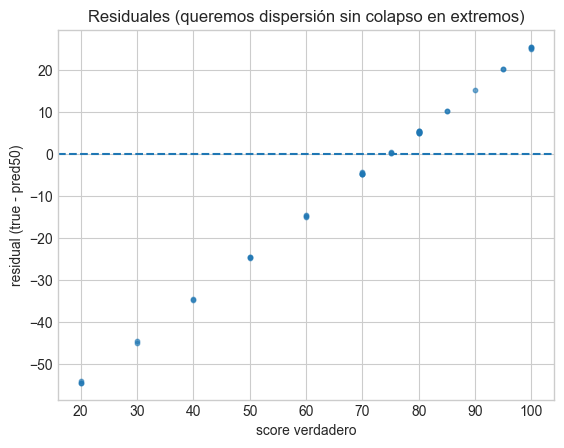

In [249]:

# Predicciones en val
def predict_ds(ds, model):
    y_true, y_pred50, y_q10, y_q90 = [], [], [], []
    for (x, y), w in ds:
        # x = imagen tensor, y = {'score': ..., 'flags': ...}
        q10, q50, q90, _ = model.base([x, y["score"], y["flags"]], training=False)
        y_true.append(tf.squeeze(y["score"]).numpy())
        y_pred50.append(tf.squeeze(q50).numpy())
        y_q10.append(tf.squeeze(q10).numpy())
        y_q90.append(tf.squeeze(q90).numpy())
    y_true = np.concatenate(y_true)
    y_pred50 = np.concatenate(y_pred50)
    y_q10 = np.concatenate(y_q10)
    y_q90 = np.concatenate(y_q90)
    return y_true, y_pred50, y_q10, y_q90


y_true_v, y50_v, y10_v, y90_v = predict_ds(val_ds, trainer)
# Devolver a escala 0-100
y_true_v = (y_true_v * 100.0).clip(0, 100)
y50_v = (y50_v * 100.0).clip(0, 100)
y10_v = (y10_v * 100.0).clip(0, 100)
y90_v = (y90_v * 100.0).clip(0, 100)

def mae(a, b): return float(np.mean(np.abs(a-b)))

print("MAE global (q50):", round(mae(y_true_v, y50_v), 3))

# MAE por bandas
bins = [0, 40, 55, 70, 85, 100]
band = np.digitize(y_true_v, bins) - 1
for i in range(len(bins)-1):
    m = band == i
    if np.any(m):
        print(f"MAE banda {bins[i]}-{bins[i+1]}:", round(mae(y_true_v[m], y50_v[m]), 3))

# y_true dentro [q10, q90]
coverage = np.mean((y_true_v >= y10_v) & (y_true_v <= y90_v))
print("Cobertura cuantil [10%,90%]:", round(coverage,3))

# residuales vs verdad
plt.figure()
plt.scatter(y_true_v, y_true_v - y50_v, s=10, alpha=0.6)
plt.axhline(0, linestyle="--")
plt.xlabel("score verdadero")
plt.ylabel("residual (true - pred50)")
plt.title("Residuales (queremos dispersión sin colapso en extremos)")
plt.show()



## Calibración post‑hoc (opcional)
Si notas **sesgo global** (p.ej. comprime arriba/abajo), ajusta `q50` con **IsotonicRegression** en `val` y aplícalo a `test`.


In [250]:

iso = IsotonicRegression(out_of_bounds="clip")
iso.fit(y50_v, y_true_v)  # calibrar mediana
y50_cal = iso.transform(y50_v)
print("MAE calibrado (q50->iso):", round(mae(y_true_v, y50_cal), 3))
import joblib
joblib.dump(iso, "isotonic_calibrator.joblib")



MAE calibrado (q50->iso): 15.308


['isotonic_calibrator.joblib']

 Calibrador isotónico cargado correctamente.


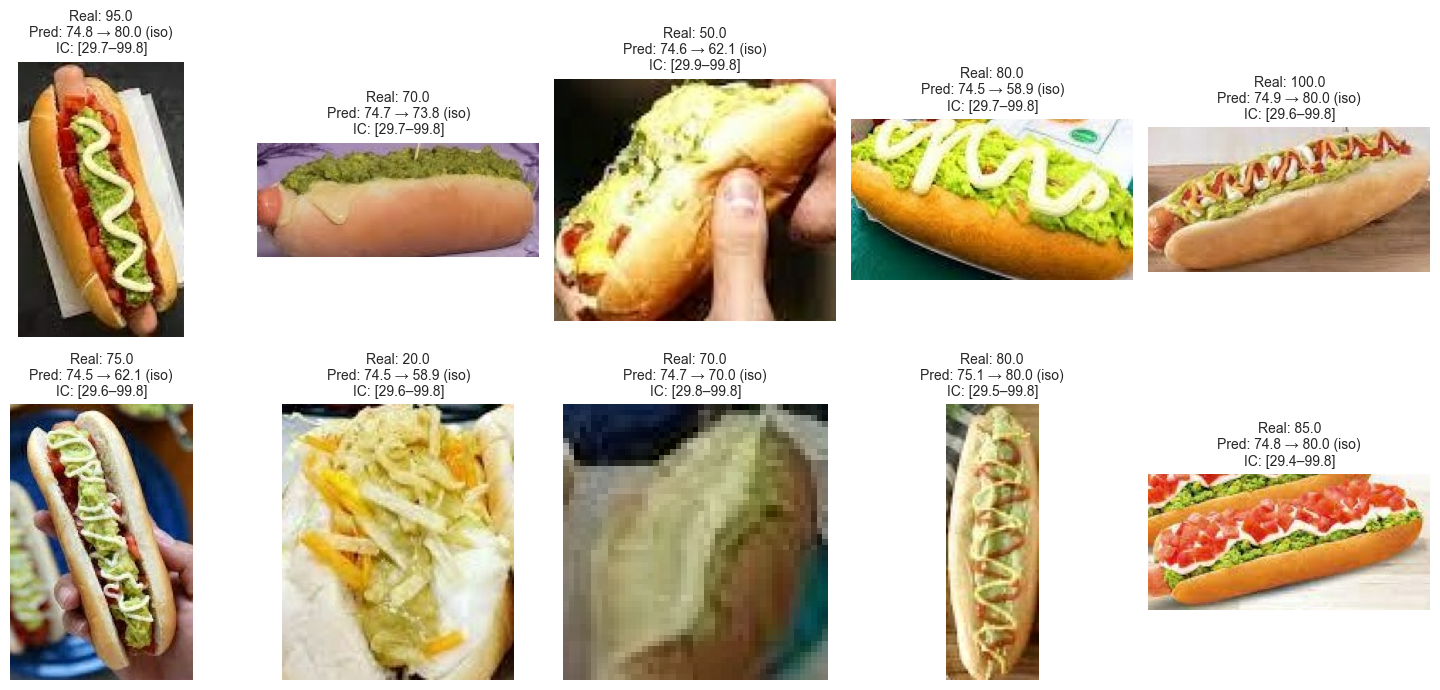

In [251]:

import os, random
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import joblib

IMG_SIZE = 224

#   cargar modelo base  
try:
    infer_model = trainer.base
except NameError:
    infer_model = tf.keras.models.load_model("best_quantile.h5", compile=False)

#   cargar calibrador  
try:
    iso = joblib.load("isotonic_calibrator.joblib")
    print(" Calibrador isotónico cargado correctamente.")
except:
    print(" Calibrador no encontrado. Ejecuta antes la celda de ajuste con IsotonicRegression.")
    iso = None

#   muestras aleatorias del set de validación  
samples = val_df.sample(10, random_state=42)

plt.figure(figsize=(15, 7))

for i, row in enumerate(samples.itertuples(), 1):
    path = row.crop_path
    if not os.path.exists(path):
        continue

    #   preparar imagen  
    img = tf.image.decode_jpeg(tf.io.read_file(path), channels=3)
    img_resized = tf.image.resize(img, (IMG_SIZE, IMG_SIZE))
    img_norm = tf.cast(img_resized, tf.float32) / 255.0
    img_input = tf.expand_dims(img_norm, 0)

    #   dummy inputs  
    dummy_score = tf.zeros((1,))
    dummy_flags = tf.zeros((1, 4))

    #   inferencia  
    q10, q50, q90, fhat = infer_model.predict([img_input, dummy_score, dummy_flags], verbose=0)

    #   extraer escalares  
    q10 = float(np.ravel(q10)[0]) * 100.0
    q50 = float(np.ravel(q50)[0]) * 100.0
    q90 = float(np.ravel(q90)[0]) * 100.0

    #   aplicar calibración isotónica  
    if iso is not None:
        q50_cal = iso.transform([[q50]])[0]  # ya en escala 0–100
    else:
        q50_cal = q50

    real = row.score_clean

    #   mostrar  
    plt.subplot(2, 5, i)
    plt.imshow(img.numpy().astype("uint8"))
    plt.axis("off")
    plt.title(
        f"Real: {real:.1f}\nPred: {q50:.1f} → {q50_cal:.1f} (iso)\nIC: [{q10:.1f}–{q90:.1f}]",
        fontsize=10
    )

plt.tight_layout()
plt.show()


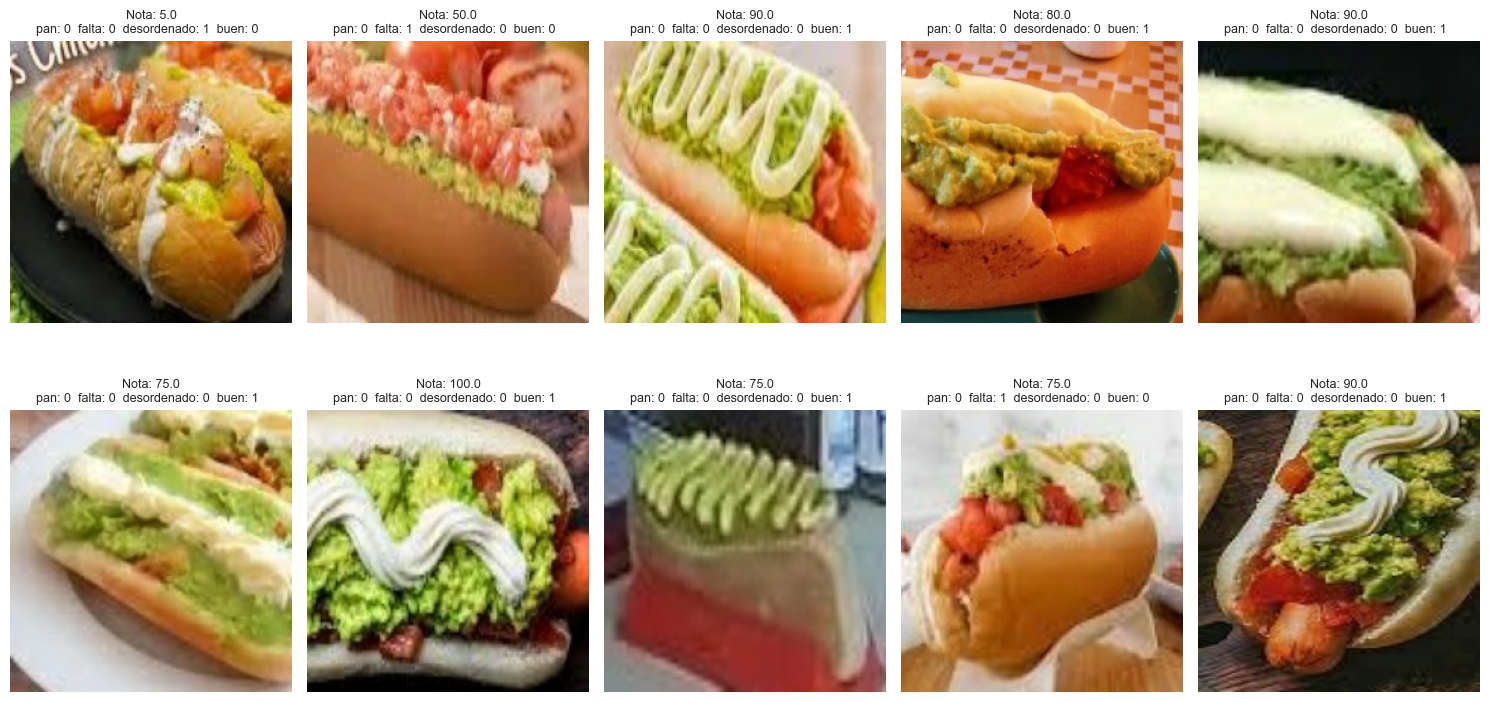

In [256]:
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np

# elige el dataframe (train_df o val_df)
df_show = train_df.sample(10, random_state=50).reset_index(drop=True)

# nombres de tus columnas
flag_cols = ['pan_quemado', 'falta_ingrediente', 'desordenado', 'buen_balance_visual']

plt.figure(figsize=(15, 8))

for i, row in df_show.iterrows():
    img = tf.io.read_file(row['crop_path'])
    img = tf.image.decode_image(img, channels=3)
    img = tf.image.resize(img, (224, 224))
    plt.subplot(2, 5, i+1)
    plt.imshow(img.numpy().astype(np.uint8))
    plt.axis("off")

    # etiqueta principal
    title = f"Nota: {row['score_clean']:.1f}\n"
    for c in flag_cols:
        val = int(row[c])
        title += f"{c.split('_')[0]}: {val}  "
    plt.title(title, fontsize=9)

plt.tight_layout()
plt.show()


## Integración de criterios culinarios con visión por computadora

El módulo de visión no solo busca predecir una nota global, sino **aproximar el razonamiento de un chef profesional al evaluar un completo**.  
Para ello, se analizan atributos visuales que representan los mismos criterios que usaría un experto:

| Criterio | Qué representa | Enfoque de visión por computador |
|   --|     -|           -|
| **Color y frescura** | Vitalidad de los ingredientes, contraste visual | Saturación y balance de color (espacio HSV) |
| **Distribución de ingredientes** | Uniformidad en el armado | Varianza espacial de color por cuadrantes |
| **Textura** | Consistencia visual de palta, pan y salsas | Varianza del filtro Laplaciano |
| **Presentación / limpieza** | Simetría y bordes definidos | Detección de bordes y diferencia izquierda–derecha |

A continuación se calculan métricas simples sobre los recortes del modelo (sin depender de Machine Learning) para cuantificar estos aspectos.
